In [1]:
import string
import itertools
import numpy as np
import pandas as pd
import glob

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.colors import LogNorm

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.1, rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [3]:
import mdtraj as md

# Analysis of interactions

In [4]:
def unit_normal_vector(v1, v2):
    """Calculates the unit normal vector to a plane defined by two vectors.

    Args:
        v1: The first vector defining the plane.
        v2: The second vector defining the plane.

    Returns:
        The unit normal vector to the plane.
    """

    normal = np.cross(v1, v2, axisa=1)
    norm = np.linalg.norm(normal, axis=1).reshape(np.shape(normal)[0],1)
    normal = normal / norm
    return normal

In [5]:
def get_normal(coords, id, sidechain_atoms):
    """
    Calculate the normal vector to the plane defined by three atoms

    Parameters
    ----------
        coords: 
            The coordinates of the atoms
    Returns
    -------
        normal: 
            The normal vector to the plane defined by the three atoms

    """
    try: 
        i, j, k = [x.index for x in coords.topology.residue(id).atoms if x.name in sidechain_atoms]
        displacements = md.compute_displacements(coords, [[i,j], [i,k]])
        normal = unit_normal_vector(displacements[:,0,:], displacements[:,1,:])
        return normal
    except ValueError as e:
        print (e)
        return None

In [6]:
pdb_name = []
theta = []; theta1 = []; theta2 = []
dmin = []
for pdb_file in glob.glob('structures/*.pdb'):
    print (pdb_file)
    pdb_name.append(pdb_file.split('/')[-1].split('.pdb')[0])
    pdb_coords = md.load_pdb(pdb_file)
    print (pdb_coords.topology.to_dataframe())

    # compute minimum distance between aromatic and charged sidechains
    aro_side = pdb_coords.top.select('element C and resname PHE TYR')
    charged_side = pdb_coords.top.select('element N and resname ARG LYS')
    atom_pairs = list(itertools.product(aro_side, charged_side))
    #print (aro_side)
    #print (charged_side)
    dmin.append(np.min((md.compute_distances(pdb_coords, atom_pairs=atom_pairs, \
                                          periodic=False))))

    # compute displacement vector between aromatic and charged sidechains
    displacement = md.compute_displacements(pdb_coords, \
                list(itertools.product(charged_side, aro_side)), periodic=False)[0]
    dvec = np.mean(displacement, axis=0)
    dvec_mod = np.linalg.norm(dvec)
    dvec_unit = dvec/dvec_mod
    
    # Compute the normal vector to the plane defined by the sidechain atoms
    n_i = get_normal(pdb_coords, 0, ['C1', 'C2', 'C3'])
    #print ([np.arccos((n_i*dvec_unit).sum())*180/np.pi, \
    #                np.arccos((-n_i*dvec_unit).sum())*180/np.pi])
    theta1.append(np.min([np.arccos((n_i*dvec_unit).sum()), \
                    np.arccos((-n_i*dvec_unit).sum())]))
    
    # For arginine, compute the normal vector to the guanidinium group plane
    if 'Arg' in pdb_file:
        n_j = get_normal(pdb_coords, 1, [a.name for a in pdb_coords.topology.atoms \
                                     if 'N' in a.name])
        theta.append(np.min([np.arccos((n_j*n_i).sum()), \
            np.arccos((-n_j*n_i).sum())]))
        theta2.append(np.min([np.arccos((n_j*dvec_unit).sum()), \
            np.arccos((-n_j*dvec_unit).sum())]))
    else:
        theta.append(None)
        theta2.append(None)
contacts_qm_df = pd.DataFrame({'pdb': pdb_name, 'dmin': dmin, 'theta': theta, 'theta1': theta1, 'theta2': theta2})
#contacts_df = pd.DataFrame({'pdb': pdb_name, 'dmin': dmin, 'theta1': np.array(theta1)*180/np.pi})

structures/ArgPhe.pdb
(    serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     PHE        0          
1        2   C2       C       1     PHE        0          
2        3   C3       C       1     PHE        0          
3        4   C4       C       1     PHE        0          
4        5   C5       C       1     PHE        0          
5        6   C6       C       1     PHE        0          
6        7   C7       C       1     PHE        0          
7        8   C8       C       2     ARG        0          
8        9   N9       N       2     ARG        0          
9       10  N10       N       2     ARG        0          
10      11  C11       C       2     ARG        0          
11      12  C12       C       2     ARG        0          
12      13  N13       N       2     ARG        0          
13      14  C14       C       2     ARG        0          , array([], shape=(0, 4), dtype=float64))
structures/LysPhe.pdb
(    serial name element  res

In [7]:
[a.name for a in pdb_coords.topology.atoms if 'N' in a.name]

['N9', 'N11', 'N12']

In [8]:
contacts_qm_df

,pdb,dmin,theta,theta1,theta2
0,ArgPhe,0.340676,0.188631,0.408149,0.596482
1,LysPhe,0.345352,NaN,0.174681,NaN
2,ArgTyrP,0.343716,0.033337,0.415845,0.443427
3,ArgTyrT,0.335830,1.363216,0.599729,1.309591
4,ArgPheT,0.336983,1.531633,0.029956,1.529326
5,LysTyr,0.334311,NaN,0.916344,NaN
6,ArgTyr,0.367168,1.480512,1.540596,0.996931


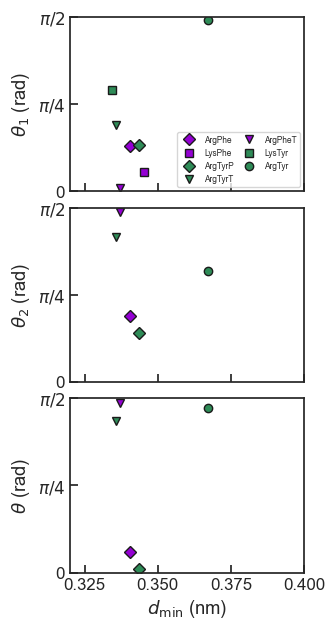

In [16]:
fig, ax = plt.subplots(3,1, figsize=(3.5,6.5), sharex=True, sharey=True)
for i,v in contacts_qm_df.iterrows():
    color = ['seagreen' if 'Tyr' in v['pdb'] else 'darkviolet'][0]

    symbol = 'o'
    if 'Lys' in v['pdb']:
        symbol = 's'
    elif 'TyrT' in v['pdb'] or 'PheT' in v['pdb']:
        symbol = 'v'
    elif 'TyrP' in v['pdb'] or 'Phe' in v['pdb']:
        symbol = 'D'
    ax[0].plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
    ax[1].plot(v['dmin'], v['theta2'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
    ax[2].plot(v['dmin'], v['theta'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax[0].set_xlim(0.32, 0.4)
ax[0].set_ylim(0, np.pi/2)
ax[0].set_yticks([0, np.pi/4, np.pi/2])
ax[0].set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax[0].set_ylabel(r'$\theta_1$ (rad)')
ax[1].set_ylabel(r'$\theta_2$ (rad)')
ax[2].set_ylabel(r'$\theta$ (rad)')
ax[-1].set_xlabel('$d_\mathrm{min}$ (nm)')
ax[0].legend(fontsize=6, loc=4, ncols=2, columnspacing=0.8)
plt.tight_layout(h_pad=0)

## Combine with PDB data

In [17]:
culled = "../PDBanalysis/cullpdb_pc15.0_res0.0-1.5_len40-10000_R0.25_Xray_d2025_02_19_chains1916.txt"
with open(culled, 'r') as f:
    raw = f.readlines()
pdbids = [r.split()[0] for r in raw][1:]
print(pdbids)

['5D8VA', '3NIRA', '5NW3A', '1UCSA', '3X2MA', '2VB1A', '1US0A', '6E6OA', '6S2MA', '1R6JA', '4REKA', '4I8HA', '2WFIA', '2OV0A', '2B97A', '8C5NA', '3X34A', '7KR0A', '6L27A', '5YCEA', '1GCIA', '7A5MA', '5GV8A', '6ZM8A', '1X6ZA', '4UA6A', '5TDAA', '7AF2AAA', '3UI4A', '5AL6A', '5NFMA', '1W0NA', '5HB7A', '2VXNA', '1NWZA', '8C3XA', '7AVKA', '2JFRA', '2O9SA', '4Y9WA', '6TGUA', '1P9GA', '7BNHA', '2O7AA', '2YKZA', '4EICA', '6EIOA', '4PSSA', '4AYOA', '6Q00A', '6Q00B', '3O4PA', '6ETLA', '1MC2A', '1X8QA', '7BBXA', '7AOTA', '3QPAA', '2FMAA', '5XVTA', '2F01A', '1G6XA', '3WDNA', '1MUWA', '3ZSJA', '6ZPAA', '2DDXA', '1V6PA', '8EREA', '4HS1A', '5L87A', '1GWEA', '3ZOJA', '3FILA', '4F1VA', '5LP9A', '1I1WA', '4U9HL', '4U9HS', '6KFNA', '8JZ8A', '7TVLA', '4O6UA', '4UYRA', '3IP0A', '8PB5A', '8AVUA', '4WEEA', '4Y9VA', '1IX9A', '6KLZA', '7OUZA', '6FMCA', '4NPDA', '1VYRA', '8VOLA', '7PSYA', '3VORA', '3G21A', '5GJIA', '3ZR8X', '4EA9A', '2XU3A', '6LK1A', '1J0PA', '5IG6A', '5BR4A', '3X0IA', '8CR4A', '5MK9A', '4HNOA'

In [18]:
pdb_coords = {}
res_names = ['PHE', 'TYR', 'ARG', 'LYS']
# Loop over all PDB files
for prot in pdbids:
    try:
        # Load the PDB file
        pdb_file = md.load_pdb("../PDBanalysis/PDB/pdb%s.ent"%prot.lower()[:4])
    except FileNotFoundError as e:
        print ("File %s not found" % (prot[:4]))
        #print (e)
        continue

    # Select the chain ID from the PDB file
    try:
        chainid = string.ascii_uppercase.index(prot[4])
    except ValueError as e:
        print (e)
        print (prot)
        continue

    try:
        sel = pdb_file.top.select('chainid %i'%chainid)
        pdb_file = pdb_file.atom_slice(sel)
    except IndexError as e:
        print ("Chain %s not found in %s" % (prot[4], prot[:4]))
        continue

    # Select residues
    try:
        sel = []
        for name in res_names:
            sel += list(pdb_file.top.select('resname %s and symbol != H'%name))
        sel = sorted(sel)
    except Exception as e:
        print (e)
        break
    pdb_coords[prot] = pdb_file[0].atom_slice((sel)) 

File 7AF2 not found
File 8VOL not found
File 7P24 not found
File 6TN1 not found
File 8OHT not found
File 7ZUG not found
File 9GIR not found
File 6XY7 not found
File 7NQG not found
File 8OVS not found
File 9DA2 not found
File 6TWP not found
File 7QYM not found
File 7QYM not found
File 8PAE not found
File 7VUB not found
File 7AVC not found
File 7ZIL not found
File 7PJ4 not found
File 9MDC not found
File 6TAK not found
File 9F96 not found
File 7Q4T not found
File 7OMV not found
File 7OS5 not found
File 7OLW not found
File 7OST not found
substring not found
4Q4W1
substring not found
4Q4W2
substring not found
4Q4W4
File 7M1A not found
File 9BHS not found
File 7NZD not found
File 4V4M not found
File 8RQP not found
File 8AMT not found
File 9FTC not found
File 7N50 not found


In [19]:
contacts = {}
aro_sidechain = ['CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ']
charged_sidechain = ['NZ', 'NE', 'NH1', 'NH2']

pdb_ids = []
resSeqs_i = []; resSeqs_j = []
codes_i = []; codes_j = []
dmins = []; dvecs = []
thetas = []; theta1s = []; theta2s = []; ttheta1s = []; ttheta2s = [] 

for pdb, coords in pdb_coords.items(): # Loop over PDB files
    print (pdb)
    print (coords.top)
    #print ([coords.topology.residue(i).code for i in range(coords.topology.n_residues)])
    res_pairs = list(itertools.combinations(range(coords.topology.n_residues), 2))
    try:
        dist, pairs = md.compute_contacts(coords, res_pairs, periodic=False, scheme='sidechain-heavy')
    except ValueError as e:
        print (e)
        continue
    #print (list(zip(dist[0], pairs)))
    for k, d in enumerate(dist.ravel()):
        if d < 0.45:
            i, j = pairs[k][0], pairs[k][1]
            ires, jres = coords.topology.residue(i), coords.topology.residue(j)
            iseq,  jseq = coords.topology.residue(i).resSeq, coords.topology.residue(j).resSeq
            ic, jc = coords.topology.residue(i).code, coords.topology.residue(j).code

            ii, ji = coords.topology.residue(i).resSeq, coords.topology.residue(j).resSeq
            id, jd = coords.topology.residue(i).code, coords.topology.residue(j).code

            # Compute vector between sidechains
            if ic in ['F', 'Y']:
                isel = [x.index for x in coords.topology.residue(i).atoms if \
                               x.name in aro_sidechain]
            elif ic in ['R', 'K']:    
                isel = [x.index for x in coords.topology.residue(i).atoms if \
                               x.name in charged_sidechain]
            if jc in ['F', 'Y']:
                jsel = [x.index for x in coords.topology.residue(j).atoms if \
                               x.name in aro_sidechain]
            elif jc in ['R', 'K']:    
                jsel = [x.index for x in coords.topology.residue(j).atoms if \
                               x.name in charged_sidechain]
            try:
                displacement = md.compute_displacements(coords, \
                                            list(itertools.product(isel, jsel)), periodic=False)[0]
                dvec = np.mean(displacement, axis=0)
                dvec_mod = np.linalg.norm(dvec)
                dvec_unit = dvec/dvec_mod
            except ValueError as e:
                print (e)
                print ("Not enough atoms in residue pair: ", iseq, jseq)
                dvec = None
                dvec_mod = None
                dvec_unit = None
                continue
            
            # Compute the normal vector to the plane defined by the sidechain atoms
            if id in ['F', 'Y']:
                n_i = get_normal(coords, i, aro_sidechain[:3])
            elif id in ['R']:
                n_i = get_normal(coords, i, charged_sidechain[1:])
            else:
                n_i = None

            if jd in ['F', 'Y']:
                n_j = get_normal(coords, j, aro_sidechain[:3])
            elif jd in ['R']:
                n_j = get_normal(coords, j, charged_sidechain[1:])
            else:
                n_j = None
            
            theta = None; theta1 = None; theta2 = None
            ttheta1 = None; ttheta2 = None # set angles to none by default
            try:
                theta = np.min([np.arccos((n_i*n_j).sum()), np.arccos((-n_i*n_j).sum())])
            except TypeError as e:
                theta = None

            try:
                if id in ['F']:
                    if jd in ['F', 'Y']:
                        ttheta1 = np.pi/2 - np.min([np.arccos((n_i*dvec_unit).sum()), \
                                                    np.arccos((-n_i*dvec_unit).sum())])
                        ttheta2 = np.pi/2 - np.min([np.arccos((n_j*dvec_unit).sum()), \
                                                    np.arccos((-n_j*dvec_unit).sum())])
                    elif jd in ['K', 'R']:
                        theta1 = np.min([np.arccos((n_i*dvec_unit).sum()), \
                                         np.arccos((-n_i*dvec_unit).sum())])
                        theta2 = [np.min([np.arccos((n_j*dvec_unit).sum()), \
                                          np.arccos((-n_j*dvec_unit).sum())]) if jd in ['R'] else None][0]
                elif id in ['Y']:
                    if jd in ['F', 'Y']:
                        ttheta1 = np.pi/2 - np.min([np.arccos((n_j*dvec_unit).sum()), \
                                                    np.arccos((-n_j*dvec_unit).sum())])
                        ttheta2 = np.pi/2 - np.min([np.arccos((n_i*dvec_unit).sum()), \
                                                    np.arccos((-n_i*dvec_unit).sum())])
                    elif jd in ['K', 'R']:
                        theta1 = np.min([np.arccos((n_i*dvec_unit).sum()), \
                                         np.arccos((-n_i*dvec_unit).sum())])
                        theta2 = [np.min([np.arccos((n_j*dvec_unit).sum()), \
                                          np.arccos((-n_j*dvec_unit).sum())]) if jd in ['R'] else None][0]
                elif id in ['K', 'R']:
                    if jd in ['F', 'Y']:
                        theta1 = np.min([np.arccos((n_j*dvec_unit).sum()), \
                                         np.arccos((-n_j*dvec_unit).sum())])
                        theta2 = [np.min([np.arccos((n_i*dvec_unit).sum()), \
                                          np.arccos((-n_i*dvec_unit).sum())]) if id in ['R'] else None][0]
                    else:
                        theta1 = [np.min([np.arccos((n_i*dvec_unit).sum()), \
                                          np.arccos((-n_i*dvec_unit).sum())]) if id in ['R'] else None][0]
                        theta2 = [np.min([np.arccos((n_j*dvec_unit).sum()), \
                                          np.arccos((-n_j*dvec_unit).sum())]) if jd in ['R'] else None][0]
 
            except TypeError as e:
                print (e)

            pdb_ids.append(pdb)
            codes_i.append(ic); codes_j.append(jc)
            resSeqs_i.append(ires); resSeqs_j.append(jres)
            
            dmins.append(d)
            dvecs.append(dvec_mod)

            thetas.append(theta)
            theta1s.append(theta1); theta2s.append(theta2)
            ttheta1s.append(ttheta1); ttheta2s.append(ttheta2)
            
contacts_df = pd.DataFrame({'pdb': pdb_ids, 'res_i': codes_i, 'res_j': codes_j, 'resSeq_i': resSeqs_i, \
                            'resSeq_j': resSeqs_j, 'dmin': dmins, 'dvec' : dvecs, 'theta': thetas, \
                            'theta1': theta1s, 'theta2': theta2s, 'ttheta1': ttheta1s, 'ttheta2': ttheta2s})

5D8VA
<mdtraj.Topology with 1 chains, 10 residues, 101 atoms, 95 bonds>
3NIRA
<mdtraj.Topology with 1 chains, 5 residues, 57 atoms, 55 bonds>
5NW3A
<mdtraj.Topology with 1 chains, 9 residues, 192 atoms, 87 bonds>
1UCSA
<mdtraj.Topology with 1 chains, 6 residues, 59 atoms, 54 bonds>
3X2MA
<mdtraj.Topology with 1 chains, 20 residues, 216 atoms, 213 bonds>
2VB1A
<mdtraj.Topology with 1 chains, 23 residues, 244 atoms, 231 bonds>
1US0A
<mdtraj.Topology with 1 chains, 57 residues, 588 atoms, 560 bonds>
6E6OA
<mdtraj.Topology with 1 chains, 5 residues, 59 atoms, 58 bonds>
6S2MA
<mdtraj.Topology with 1 chains, 32 residues, 705 atoms, 301 bonds>
1R6JA
<mdtraj.Topology with 1 chains, 10 residues, 101 atoms, 95 bonds>
4REKA
<mdtraj.Topology with 1 chains, 90 residues, 967 atoms, 929 bonds>
4I8HA
<mdtraj.Topology with 1 chains, 29 residues, 301 atoms, 286 bonds>
2WFIA
<mdtraj.Topology with 1 chains, 39 residues, 407 atoms, 391 bonds>
2OV0A
<mdtraj.Topology with 1 chains, 18 residues, 186 atoms, 17

In [20]:
contacts_df

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
0,5D8VA,Y,F,TYR19,PHE64,0.448051,0.590764,0.913655,NaN,NaN,1.067686,1.1534
1,5D8VA,F,K,PHE64,LYS67,0.422619,0.794475,NaN,1.442892,NaN,NaN,NaN
2,3NIRA,R,F,ARG10,PHE13,0.433863,0.585247,1.233658,0.517593,0.875230,NaN,NaN
3,3NIRA,F,R,PHE13,ARG17,0.362366,0.657059,0.793855,0.978311,1.031952,NaN,NaN
4,5NW3A,K,F,LYS6,PHE48,0.310219,0.940045,NaN,0.882583,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32188,2IT2A,R,R,ARG104,ARG152,0.332336,0.397486,1.072557,0.349956,0.932339,NaN,NaN
32189,2IT2A,F,K,PHE130,LYS187,0.370562,0.648984,NaN,0.183362,NaN,NaN,NaN
32190,2IT2A,Y,R,TYR132,ARG148,0.327819,0.461523,1.180847,0.635105,0.722974,NaN,NaN
32191,2IT2A,K,R,LYS187,ARG190,0.339773,0.684704,NaN,NaN,1.450844,NaN,NaN


### Arg - Tyr interactions

In [40]:
sel = pd.DataFrame([(contacts_df.res_i == 'Y') & (contacts_df.res_j == 'R'), \
                    (contacts_df.res_i == 'R') & (contacts_df.res_j == 'Y')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
29,2VB1A,Y,R,TYR20,ARG21,0.346485,0.477257,0.461955,0.697546,0.646792,NaN,NaN
34,2VB1A,Y,R,TYR53,ARG68,0.319916,0.697329,1.028186,1.468951,1.175047,NaN,NaN
41,1US0A,R,Y,ARG69,TYR103,0.331811,0.394170,0.177689,0.540974,0.468327,NaN,NaN
47,1US0A,Y,R,TYR189,ARG232,0.403743,0.662861,0.675075,1.364100,1.362535,NaN,NaN
49,1US0A,Y,R,TYR189,ARG293,0.379315,0.617137,0.943098,0.258059,1.060859,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32164,3BHWA,Y,R,TYR6,ARG133,0.292062,0.520903,0.949958,1.122871,1.401330,NaN,NaN
32173,3BHWA,R,Y,ARG120,TYR153,0.351218,0.451652,0.130757,0.560728,0.648436,NaN,NaN
32174,3BHWA,R,Y,ARG120,TYR168,0.314083,0.578940,1.067368,1.012969,1.563916,NaN,NaN
32175,3BHWA,Y,R,TYR126,ARG133,0.365950,0.573860,0.938577,0.883296,1.524345,NaN,NaN


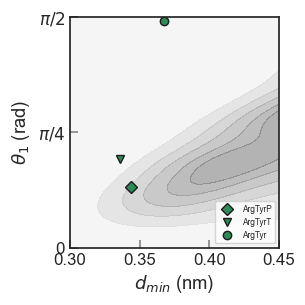

In [42]:
xmin = 0.3; xmax = 0.45
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Tyr' in v['pdb'] and 'Arg' in v['pdb']:
        color = ['seagreen' if 'Tyr' in v['pdb'] else 'darkviolet'][0]
        symbol = ['s' if 'Lys' in v['pdb'] else 'o'][0]
        if 'TyrT' in v['pdb']:
            symbol = 'v'
        elif 'TyrP' in v['pdb']:
            symbol = 'D'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

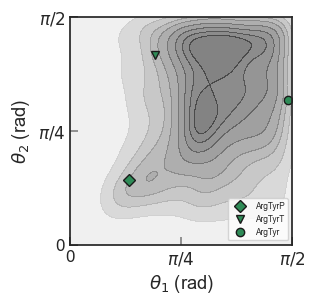

In [29]:
fig, ax = plt.subplots(figsize=(3.35, 3.25))

xmin = 0; xmax = np.pi/2
ymin = 0; ymax = np.pi/2
sns.kdeplot(data=contacts_df[sel], x='theta1', y='theta2', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)
for i,v in contacts_qm_df.iterrows():
    if 'Tyr' in v['pdb'] and 'Arg' in v['pdb']:
        color = ['seagreen' if 'Tyr' in v['pdb'] else 'darkviolet'][0]
        symbol = 'o'
        if 'TyrT' in v['pdb']:
            symbol = 'v'
        elif 'TyrP' in v['pdb']:
            symbol = 'D'
        ax.plot(v['theta1'], v['theta2'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks([0, np.pi/4, np.pi/2])
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel(r'$\theta_1$ (rad)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

### Arg-Phe interactions

In [43]:
sel = pd.DataFrame([(contacts_df.res_i == 'F') & (contacts_df.res_j == 'R'), \
                    (contacts_df.res_i == 'R') & (contacts_df.res_j == 'F')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
2,3NIRA,R,F,ARG10,PHE13,0.433863,0.585247,1.233658,0.517593,0.875230,NaN,NaN
3,3NIRA,F,R,PHE13,ARG17,0.362366,0.657059,0.793855,0.978311,1.031952,NaN,NaN
18,3X2MA,R,F,ARG56,PHE58,0.357700,0.780990,0.976082,0.998889,1.336324,NaN,NaN
28,2VB1A,R,F,ARG5,PHE38,0.376486,0.911797,0.669213,1.164317,1.514359,NaN,NaN
33,2VB1A,F,R,PHE34,ARG114,0.337095,0.446827,0.278782,0.753982,0.615590,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32094,6QW0A,F,R,PHE192,ARG196,0.361243,0.539625,1.454358,0.745239,1.559617,NaN,NaN
32108,1SZHA,F,R,PHE140,ARG144,0.386170,0.638509,0.571877,0.783283,1.201865,NaN,NaN
32139,2QVGA,F,R,PHE93,ARG113,0.357562,0.643795,0.420669,1.267818,0.928891,NaN,NaN
32157,4W8PA,F,R,PHE1550,ARG1555,0.390853,0.469463,0.664226,0.846771,0.233000,NaN,NaN


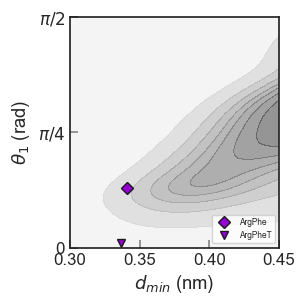

In [45]:
xmin = 0.3; xmax = 0.45
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Phe' in v['pdb'] and 'Arg' in v['pdb']:
        color = 'darkviolet'
        symbol = 'D'
        if 'PheT' in v['pdb']:
            symbol = 'v'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

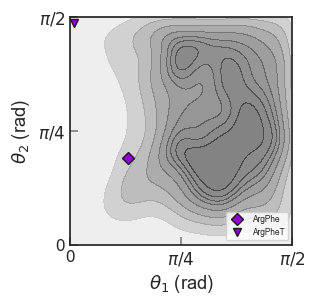

In [34]:
fig, ax = plt.subplots(figsize=(3.35, 3.25))

xmin = 0; xmax = np.pi/2
ymin = 0; ymax = np.pi/2
sns.kdeplot(data=contacts_df[sel], x='theta1', y='theta2', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)
for i,v in contacts_qm_df.iterrows():
    if 'Phe' in v['pdb'] and 'Arg' in v['pdb']:
        color = 'darkviolet'
        symbol = 'D'
        if 'PheT' in v['pdb']:
            symbol = 'v'
        ax.plot(v['theta1'], v['theta2'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xticks([0, np.pi/4, np.pi/2])
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel(r'$\theta_1$ (rad)')
ax.set_ylabel(r'$\theta_2$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

### Lys-Tyr interactions  

In [61]:
sel = pd.DataFrame([(contacts_df.res_i == 'Y') & (contacts_df.res_j == 'K'), \
                    (contacts_df.res_i == 'K') & (contacts_df.res_j == 'Y')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
7,5NW3A,Y,K,TYR12,LYS28,0.378688,1.234177,NaN,1.506750,NaN,NaN,NaN
30,2VB1A,Y,K,TYR20,LYS96,0.355632,0.552637,NaN,0.747607,NaN,NaN,NaN
40,1US0A,Y,K,TYR48,LYS77,0.311364,0.465353,NaN,1.056846,NaN,NaN,NaN
43,1US0A,Y,K,TYR103,LYS154,0.346777,0.436460,NaN,0.141609,NaN,NaN,NaN
46,1US0A,K,Y,LYS176,TYR177,0.362051,0.567283,NaN,0.968820,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32122,2WWXB,Y,K,TYR532,LYS533,0.403767,0.706003,NaN,1.235936,NaN,NaN,NaN
32140,2QVGA,Y,K,TYR99,LYS104,0.427702,0.921577,NaN,1.281130,NaN,NaN,NaN
32144,1Y9LA,Y,K,TYR45,LYS106,0.381202,0.799081,NaN,0.523727,NaN,NaN,NaN
32145,1Y9LA,Y,K,TYR45,LYS135,0.431713,0.687684,NaN,1.306204,NaN,NaN,NaN


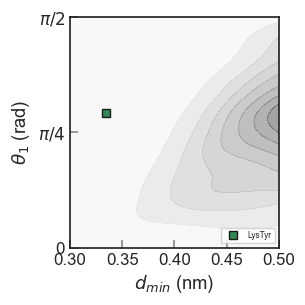

In [58]:
xmin = 0.3; xmax = 0.5
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Tyr' in v['pdb'] and 'Lys' in v['pdb']:
        color = 'seagreen'
        symbol = 's'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()

In [65]:

contacts_df[sel][contacts_df[sel]['dvec'] < 0.45]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
43,1US0A,Y,K,TYR103,LYS154,0.346777,0.436460,NaN,0.141609,NaN,NaN,NaN
153,4I8HA,Y,K,TYR184,LYS188,0.363676,0.409489,NaN,0.331104,NaN,NaN,NaN
231,6L27A,Y,K,TYR143,LYS209,0.357152,0.417930,NaN,0.567846,NaN,NaN,NaN
366,2VXNA,K,Y,LYS3,TYR223,0.365924,0.384298,NaN,0.145017,NaN,NaN,NaN
408,8C3XA,Y,K,TYR49,LYS218,0.351186,0.408398,NaN,0.651695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
31485,3N6YA,Y,K,TYR35,LYS153,0.365530,0.401768,NaN,0.364719,NaN,NaN,NaN
31669,6Y1YA,K,Y,LYS51,TYR83,0.368917,0.440805,NaN,0.721592,NaN,NaN,NaN
31761,2X49A,Y,K,TYR391,LYS581,0.294954,0.420168,NaN,1.150895,NaN,NaN,NaN
31803,7Y86A,K,Y,LYS34,TYR57,0.357883,0.428111,NaN,0.403292,NaN,NaN,NaN


### Lys-Phe interactions

In [59]:
sel = pd.DataFrame([(contacts_df.res_i == 'F') & (contacts_df.res_j == 'K'), \
                    (contacts_df.res_i == 'K') & (contacts_df.res_j == 'F')]).any()
contacts_df[sel]

,pdb,res_i,res_j,resSeq_i,resSeq_j,dmin,dvec,theta,theta1,theta2,ttheta1,ttheta2
1,5D8VA,F,K,PHE64,LYS67,0.422619,0.794475,NaN,1.442892,NaN,NaN,NaN
4,5NW3A,K,F,LYS6,PHE48,0.310219,0.940045,NaN,0.882583,NaN,NaN,NaN
10,5NW3A,K,F,LYS28,PHE29,0.234934,1.239905,NaN,1.535841,NaN,NaN,NaN
11,5NW3A,F,K,PHE29,LYS45,0.261988,0.491446,NaN,0.474389,NaN,NaN,NaN
13,5NW3A,K,F,LYS45,PHE48,0.269305,0.909799,NaN,0.546820,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32152,1Y9LA,F,K,PHE96,LYS101,0.382025,0.712239,NaN,1.302344,NaN,NaN,NaN
32181,2IT2A,F,K,PHE11,LYS15,0.396974,0.609263,NaN,1.268009,NaN,NaN,NaN
32183,2IT2A,F,K,PHE11,LYS113,0.347452,0.548812,NaN,0.783696,NaN,NaN,NaN
32184,2IT2A,K,F,LYS15,PHE49,0.365332,0.726790,NaN,1.439478,NaN,NaN,NaN


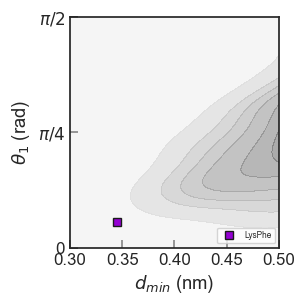

In [60]:
xmin = 0.3; xmax = 0.5
ymin = 0; ymax = np.pi/2

fig, ax = plt.subplots(figsize=(3.25, 3.25))
sns.kdeplot(data=contacts_df[sel], x='dvec', y='theta1', ax=ax, cmap='binary', \
            fill=True, thresh=0, levels=10, alpha=0.5)

for i,v in contacts_qm_df.iterrows():
    if 'Phe' in v['pdb'] and 'Lys' in v['pdb']:
        color = 'darkviolet'
        symbol = 's'
        ax.plot(v['dmin'], v['theta1'], symbol, mfc=color, mew=1, mec='k', label=v['pdb'])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([0, np.pi/4, np.pi/2])
ax.set_yticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
ax.set_xlabel('$d_{min}$ (nm)')
ax.set_ylabel(r'$\theta_1$ (rad)')
ax.legend(fontsize=6, loc=4, ncols=1, columnspacing=0.8)
plt.tight_layout()